### Problem Statement :

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

#### Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:
1.	A single cell estimate of the population 16+ for each state.
2.	Controls for Hispanic Origin by age and sex.
3.	Controls by Race, age and sex.
We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.


In [1]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore,boxcox


from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("census_income.csv")
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [4]:
df.tail()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [5]:
df.shape

(32560, 15)

In [6]:
# Checking unique value in dataset
df.nunique()

Age                  73
Workclass             9
Fnlwgt            21647
Education            16
Education_num        16
Marital_status        7
Occupation           15
Relationship          6
Race                  5
Sex                   2
Capital_gain        119
Capital_loss         92
Hours_per_week       94
Native_country       42
Income                2
dtype: int64

In [7]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [8]:
len(df.columns)

15

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


## Task

- Prediction task is to determine whether a person makes over 50K a year.

#### 14 Attribute Informaion :
 
    Age - Age is continues data
    
    Workclass - Categorical data 
    
    Fnlwgt - final weight - continues
    
    Education - [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'] 
       
    Education_num - Continues Data
    
    Marital_status - [' Married-civ-spouse', ' Divorced', ' Married-spouse-absent',
       ' Never-married', ' Separated', ' Married-AF-spouse', ' Widowed']
       
    Occupation - [' Exec-managerial', ' Handlers-cleaners', ' Prof-specialty',
       ' Other-service', ' Adm-clerical', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv']
       
    Relationship - [' Husband', ' Not-in-family', ' Wife', ' Own-child', ' Unmarried',
       ' Other-relative']
       
     Race - [' White', ' Black', ' Asian-Pac-Islander', ' Amer-Indian-Eskimo',
       ' Other']
       
     Sex - [' Male', ' Female']
       
     Capital_gain - Continues
     Capital_loss - Continues
     Hours_per_week - Continues
     
     Native_country  - [' United-States', ' Cuba', ' Jamaica', ' India', ' ?', ' Mexico',
       ' South', ' Puerto-Rico', ' Honduras', ' England', ' Canada',
       ' Germany', ' Iran', ' Philippines', ' Italy', ' Poland',
       ' Columbia', ' Cambodia', ' Thailand', ' Ecuador', ' Laos',
       ' Taiwan', ' Haiti', ' Portugal', ' Dominican-Republic',
       ' El-Salvador', ' France', ' Guatemala', ' China', ' Japan',
       ' Yugoslavia', ' Peru', ' Outlying-US(Guam-USVI-etc)', ' Scotland',
       ' Trinadad&Tobago', ' Greece', ' Nicaragua', ' Vietnam', ' Hong',
       ' Ireland', ' Hungary', ' Holand-Netherlands']
       
##### 1 Class variable       
       Income - >50K = Greater than 50k , <=50K - less than 50k

### Observation : 

    As per the above data we are getting some information
    
    - datasets having 32560 row and 15 column.
    - No null values in data so need to focus on that part
    - Some non numerical data is their so we need to encode that later.
    - As per independen and dependent variable this logistic classification algorithm.
    - We need to understand about each column to train the data.

## EDA Process

<AxesSubplot:>

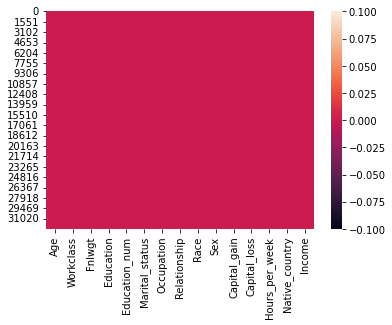

In [10]:
sns.heatmap(df.isnull())

No null value present in the data 

In [11]:
## Statistical summary of data
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Observation :

- Capital_gain ,Capital loss is  not showing median value 
- Dataset having normal ditribution as per the data
- High standard deviation in Capital_gain ,Capital loss

In [12]:
df.skew()

Age                0.558738
Fnlwgt             1.446972
Education_num     -0.311630
Capital_gain      11.953690
Capital_loss       4.594549
Hours_per_week     0.227636
dtype: float64

### Checking outlier

<AxesSubplot:xlabel='Age'>

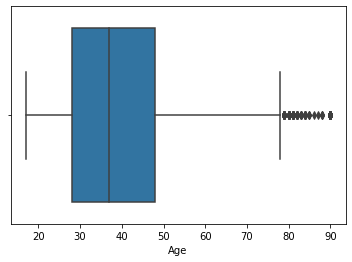

In [13]:
sns.boxplot(df['Age'])

More outlier is present but near to whisper only

<AxesSubplot:xlabel='Capital_gain'>

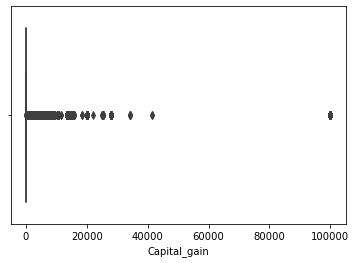

In [14]:
sns.boxplot(df['Capital_gain'])

<AxesSubplot:xlabel='Fnlwgt'>

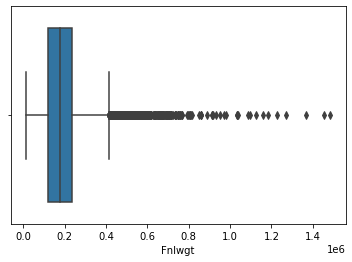

In [15]:
sns.boxplot(df['Fnlwgt'])

In [16]:
country_group = df.groupby('Native_country').sum().sort_values('Native_country')
country_group

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
Native_country,,,,,,
?,22577,112694423,6179,1053200,68949,24202
Cambodia,718,3668527,167,19529,3478,777
Canada,5148,21762205,1289,182000,15722,4889
China,3190,13428599,834,27486,13464,2834
Columbia,2343,13283815,553,10656,1602,2305
Cuba,4348,23397678,912,34887,6654,3720
Dominican-Republic,2641,13446269,498,103324,1762,2973
Ecuador,1026,5204047,265,14773,0,1108
El-Salvador,3618,26965655,725,60878,3298,3900


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 [Text(0, 0, ' United-States'),
  Text(1, 0, ' Cuba'),
  Text(2, 0, ' Jamaica'),
  Text(3, 0, ' India'),
  Text(4, 0, ' ?'),
  Text(5, 0, ' Mexico'),
  Text(6, 0, ' South'),
  Text(7, 0, ' Puerto-Rico'),
  Text(8, 0, ' Honduras'),
  Text(9, 0, ' England'),
  Text(10, 0, ' Canada'),
  Text(11, 0, ' Germany'),
  Text(12, 0, ' Iran'),
  Text(13, 0, ' Philippines'),
  Text(14, 0, ' Italy'),
  Text(15, 0, ' Poland'),
  Text(16, 0, ' Columbia'),
  Text(17, 0, ' Cambodia'),
  Text(18, 0, ' Thailand'),
  Text(19, 0, ' Ecuador'),
  Text(20, 0, ' Laos'),
  Text(21, 0, ' Taiwan'),
  Text(22, 0, ' Haiti'),
  Text(23, 0, ' Portugal'),
  Text(24, 0, ' Dominican-Republic'),
  Text(25, 0, ' El-Salvador'),
  Text(26, 0, ' France'),
  Text(27, 0, ' Guatemala'),
  Text(28, 0, ' China'),
  Text(29, 0, ' Japan'),
  

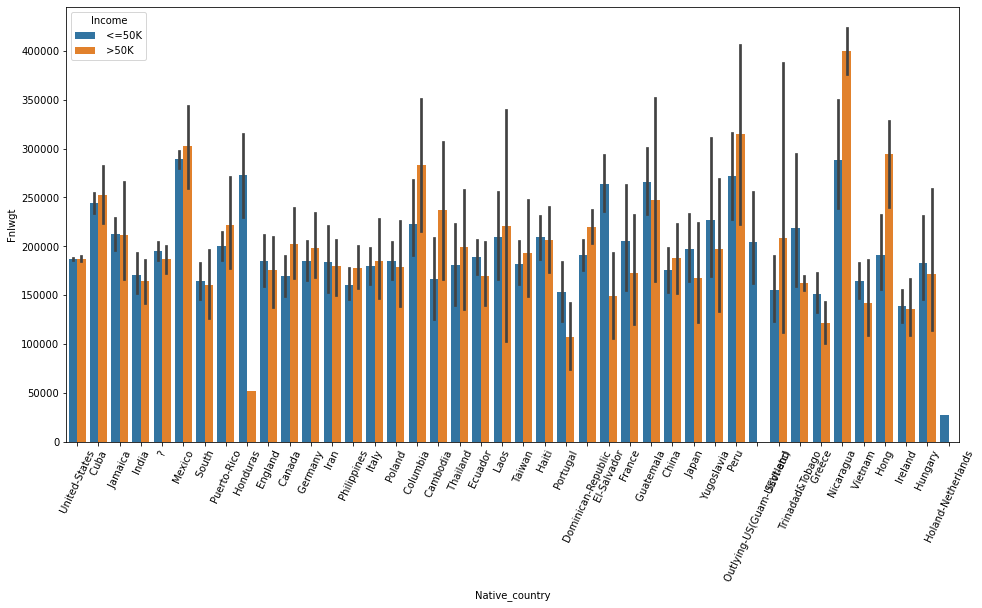

In [17]:
plt.figure(figsize=(16,8))
sns.barplot(x='Native_country',y='Fnlwgt',data=df,hue='Income')
plt.xticks(rotation=65)

    Observation :
    1.All country having almost equal ration of dependent variable
    2.Some unknown country is present in country attribute

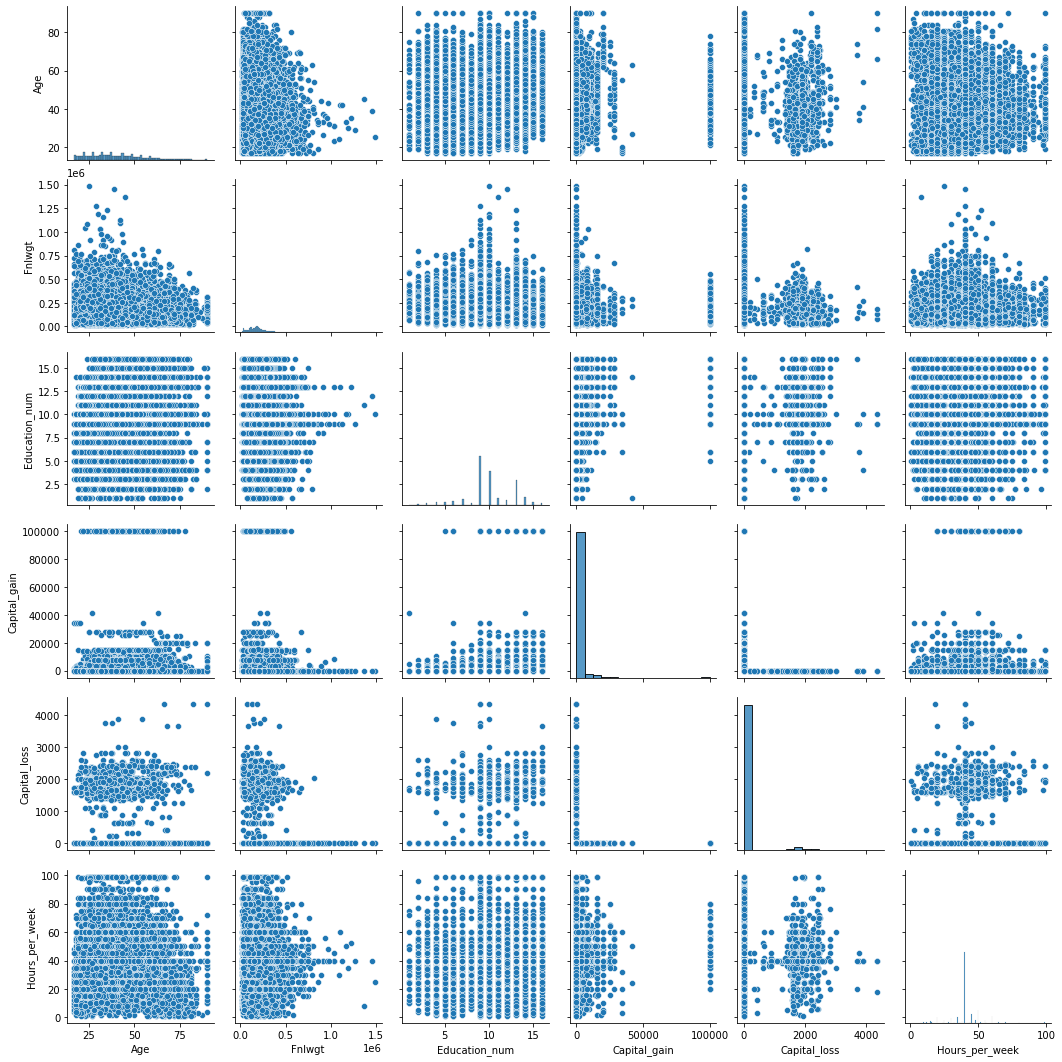

In [18]:
sns.pairplot(df)

Age                  AxesSubplot(0.125,0.536818;0.0945122x0.343182)
Fnlwgt            AxesSubplot(0.238415,0.536818;0.0945122x0.343182)
Education_num     AxesSubplot(0.351829,0.536818;0.0945122x0.343182)
Capital_gain      AxesSubplot(0.465244,0.536818;0.0945122x0.343182)
Capital_loss      AxesSubplot(0.578659,0.536818;0.0945122x0.343182)
Hours_per_week    AxesSubplot(0.692073,0.536818;0.0945122x0.343182)
dtype: object

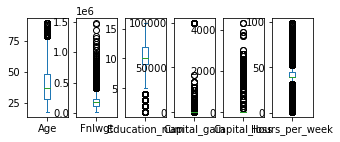

In [19]:
df.plot(kind='box',subplots=True,layout=(2,7))

In [20]:
## Changing string variable to numberical variable
num_encoder = LabelEncoder()

In [21]:
df.columns

Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_num',
       'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_gain', 'Capital_loss', 'Hours_per_week', 'Native_country',
       'Income'],
      dtype='object')

In [22]:
df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

In [23]:
df['Workclass'] = num_encoder.fit_transform(df['Workclass'])
df['Education'] = num_encoder.fit_transform(df['Education'])
df['Marital_status'] = num_encoder.fit_transform(df['Marital_status'])
df['Occupation'] = num_encoder.fit_transform(df['Occupation'])
df['Relationship'] = num_encoder.fit_transform(df['Relationship'])
df['Race'] = num_encoder.fit_transform(df['Race'])
df['Sex'] = num_encoder.fit_transform(df['Sex'])
df['Native_country'] = num_encoder.fit_transform(df['Native_country'])
df['Income'] = num_encoder.fit_transform(df['Income']) 

In [24]:
df_corr = df.corr()

In [25]:
df_corr['Income'].sort_values(ascending=False)

Income            1.000000
Education_num     0.335182
Age               0.234039
Hours_per_week    0.229690
Capital_gain      0.223333
Sex               0.215995
Capital_loss      0.150523
Education         0.079311
Occupation        0.075448
Race              0.071853
Workclass         0.051645
Native_country    0.015845
Fnlwgt           -0.009481
Marital_status   -0.199295
Relationship     -0.250924
Name: Income, dtype: float64

<AxesSubplot:>

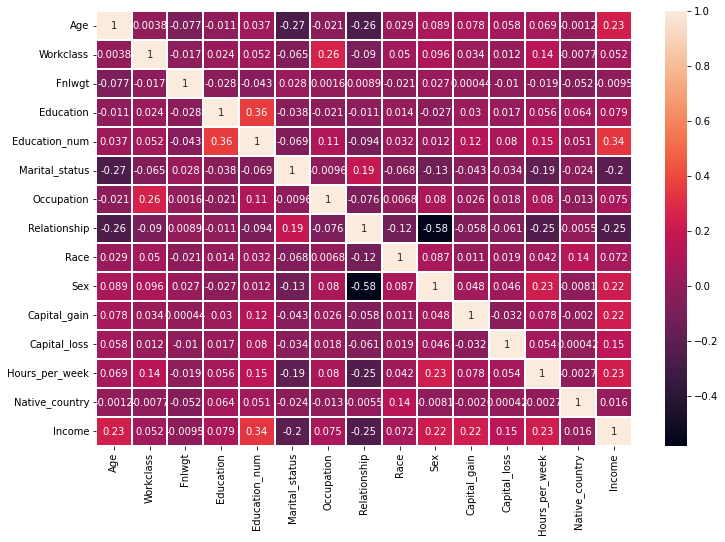

In [26]:
plt.figure(figsize=(12,8))
sns.heatmap(df_corr,linewidths=0.2,annot=True)

Observation :
        
        - Education , Age ,Hours per week is more possitive correlated 
        - Fnlwgt , Marital_status, Relationship is negatively correlated      

In [27]:
z = np.abs(zscore(df))

In [28]:
df_new =df[(z<3).all(axis=1)]

In [29]:
df_new.shape

(27417, 15)

In [30]:
df.shape

(32560, 15)

In [31]:
(32560-27417)/32560*100 # Number of dataset is more no we can remove outlier

15.795454545454547

### Spliting X and Y Data

In [32]:
x = df_new.iloc[:,0:-1]
y = df_new.iloc[:,-1]

In [33]:
x.shape

(27417, 14)

In [34]:
y.shape

(27417,)

### Finding best random state

In [35]:
maxScore = 0
maxRS = 0

for i in range(1,100):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.23,random_state=i)
    lr = LogisticRegression()
    lr.fit(x_train,y_train)
    prec= lr.predict(x_test)
    acc =accuracy_score(y_test,prec)
    
    if acc > maxScore:
        maxScore = acc
        maxRS = i

print(f"Best random state :{maxRS} and accuracy_score:{maxScore}")

Best random state :60 and accuracy_score:0.8157310497938471


#### Standard_Scaling

In [36]:
scale = StandardScaler()
x =scale.fit_transform(x)

##### Spliting the training and testing data

In [37]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.23,random_state=60)

In [38]:
# Size of the training and testing dataset
print("X_train",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

X_train (21111, 14)
y_train (21111,)
x_test (6306, 14)
y_test (6306,)


In [39]:
# Checking the accuracy of the value ,confusion matrix,classification report

def metrics_model(y_test,prec):
    print("Accuracy score is",accuracy_score(y_test,pred))
    print("."*80)
    print("Confusion matrix value is:\n",confusion_matrix(y_test,pred))
    print("."*80)
    print(classification_report(y_test,pred))

#### Training and Testing the Data

In [40]:
# logistic Regression

lr = LogisticRegression()
lr.fit(x_train,y_train)
prec= lr.predict(x_test)
metrics_model(y_test,prec)

NameError: name 'pred' is not defined

In [ ]:
# cross Validation
cross = cross_val_score(LogisticRegression(),x,y,cv=5)
cross.mean()

#### Checking with other classification model

In [41]:
dtc = DecisionTreeClassifier()
Kn  = KNeighborsClassifier(n_neighbors=5)
sv  = SVC() 

# model instance list created
model = [dtc,Kn,sv]

In [ ]:
for m in model:
    print(type(m))
    print("")
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    metrics_model(y_test,pred)

In [48]:
# DecisionTreeClassifier
cross = cross_val_score(DecisionTreeClassifier(),x,y,cv=5)
cross.mean()

0.8052668994929357

In [49]:
# KNeighborsClassifier
cross = cross_val_score(KNeighborsClassifier(),x,y,cv=5)
cross.mean()

0.8359414810821008

In [50]:
# SVC
cross = cross_val_score(SVC(),x,y,cv=5)
cross.mean()

0.8498742682275152

    Observation : 
        As per the above model and cross validation score comparation.
        Decisiontree algorithem is difference score very less.So we are 
        Choosing Decision tree clasifier.    

#### Ensemble methods

In [51]:
# Bagging
from sklearn.ensemble import RandomForestClassifier

In [52]:
rf =RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(x_train,y_train)
pred =rf.predict(x_test)
metrics_model(y_test,pred)

Accuracy score is 0.8566444655883286
................................................................................
Confusion matrix value is:
 [[4582  321]
 [ 583  820]]
................................................................................
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4903
           1       0.72      0.58      0.64      1403

    accuracy                           0.86      6306
   macro avg       0.80      0.76      0.78      6306
weighted avg       0.85      0.86      0.85      6306



In [53]:
# Boosting algarithem
from sklearn.ensemble import AdaBoostClassifier

In [54]:
adb =AdaBoostClassifier()
adb.fit(x_train,y_train)
prec=adb.predict(x_test)
metrics_model(y_test,prec)

Accuracy score is 0.8566444655883286
................................................................................
Confusion matrix value is:
 [[4582  321]
 [ 583  820]]
................................................................................
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4903
           1       0.72      0.58      0.64      1403

    accuracy                           0.86      6306
   macro avg       0.80      0.76      0.78      6306
weighted avg       0.85      0.86      0.85      6306



In [55]:
# Adabooster
cross = cross_val_score(AdaBoostClassifier(),x,y,cv=5)
cross.mean()

0.8589563883752884

Finally We are choosing Decisiontree algorithem due to difference between score of model and cross validation score is almost near to zero

### HyperParameterTuning

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
param = {'criterion' :['gini', 'entropy'],
        'splitter' : ['best', 'random']
        }

In [58]:
gr = GridSearchCV(DecisionTreeClassifier(),param,cv=5)
gr.fit(x_train,y_train)
gr.best_params_

{'criterion': 'entropy', 'splitter': 'best'}

In [59]:
dct = DecisionTreeClassifier(criterion='entropy',splitter='best')
dct.fit(x_train,y_train)
prec = dct.predict(x_test)
metrics_model(y_test,prec)

Accuracy score is 0.8566444655883286
................................................................................
Confusion matrix value is:
 [[4582  321]
 [ 583  820]]
................................................................................
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4903
           1       0.72      0.58      0.64      1403

    accuracy                           0.86      6306
   macro avg       0.80      0.76      0.78      6306
weighted avg       0.85      0.86      0.85      6306



#### Metrics : AUC ROC Curve

In [60]:
# lib
from sklearn.metrics import roc_curve,roc_auc_score,plot_roc_curve

In [61]:
Y_pred_pb =dct.predict_proba(x_test)[:,1]

In [62]:
roc_auc_score(y_test,Y_pred_pb)

0.7355748564198189

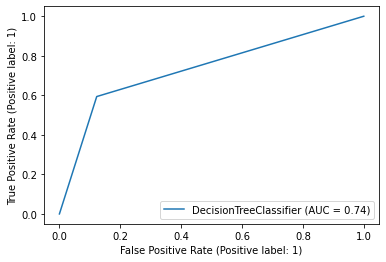

In [63]:
plot_roc_curve(dct,x_test,y_test)

### Saving the model

In [64]:
import joblib
joblib.dump(dct,"Census_income.obj")

['Census_income.obj']

In [65]:
#loding model to file

job=joblib.load("Census_income.obj")
job

DecisionTreeClassifier(criterion='entropy')

In [66]:
prec = job.predict(x_test)

In [67]:
np.unique(prec)

array([0, 1])